In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
# import textblob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

### **Plan of Action**

1. Load data
2. EDA
3. Feature engineering
4. Topic modelling
    - Top2Vec
5. Repeat step 4

In [2]:
df = pd.read_csv('../topic_data.csv')

In [3]:
df_copy = df.copy()
df_copy.describe()

raw_text_length    year        month  cleaned_text_length
count      4568.000000  4568.0  4568.000000          4568.000000
mean         27.330560  2023.0     3.703590            24.769483
std          11.840659     0.0     0.456724            11.581002
min           1.000000  2023.0     3.000000             1.000000
25%          17.000000  2023.0     3.000000            15.000000
50%          27.000000  2023.0     4.000000            24.000000
75%          37.000000  2023.0     4.000000            34.000000
max          61.000000  2023.0     4.000000            57.000000

In [4]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [5]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [6]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


In [7]:
featured_data = df_memory[['text']]

In [8]:
featured_data

text
0     "Ah, yes. I just love waking up to the sweet a...
1     When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...
2     Exclusive — Rep. Jeff Van Drew: Democrats Afra...
3     It’s April 03, 2023 at 12:29PM\nStop Your Peri...
4     #PMAtCBIDiamondJubilee\nCorruption and dynasti...
...                                                 ...
4563  If the Word cannot provoke you to preach the g...
4564  cept\nmy own and that of the manager.\n\n"'My ...
4565  Graham Potter's Chelsea exit set for huge impa...
4566  How to watch Manchester United vs Brentford - ...
4567  Erik ten Hag has contradicted himself over Wou...

[4568 rows x 1 columns]

In [9]:
docs = featured_data['text'].tolist()

In [10]:
docs[0]

'"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm'

### **Top2Vec**

In [11]:
from top2vec import Top2Vec

Top2Vec takes care of the preprocessing for us.

In [12]:
model = Top2Vec(docs, embedding_model='all-MiniLM-L6-v2',workers=2,ngram_vocab=False,speed="deep-learn")  
# The embedding module is 80MB
# Using bigrams
# doc2vec & fast-learn" is used by default

2023-04-17 12:39:10,964 - top2vec - INFO - Pre-processing documents for training
2023-04-17 12:39:13,143 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2023-04-17 12:39:29,895 - top2vec - INFO - Creating joint document/word embedding
2023-04-17 12:40:38,221 - top2vec - INFO - Creating lower dimension embedding of documents
2023-04-17 12:41:56,893 - top2vec - INFO - Finding dense areas of documents
2023-04-17 12:41:57,773 - top2vec - INFO - Finding topics


**Get Number of Topics**

In [13]:
model.get_num_topics()

35

In [14]:
len(model.vocab)

289

This will return the number of topics that Top2Vec has found in the data.

**Get Topic Sizes**

In [15]:
topic_sizes, topic_nums = model.get_topic_sizes()

This will return the number of documents most similar to each topic. Topics are in decreasing order of size.

In [16]:
topic_sizes # The number of documents most similar to each topic.

array([915, 393, 392, 277, 255, 251, 220, 198, 132, 126, 122,  97,  89,
        87,  82,  74,  67,  65,  63,  62,  55,  53,  53,  49,  46,  46,
        44,  39,  38,  37,  34,  32,  28,  25,  22], dtype=int64)

In [17]:
topic_nums # 35 topics
# The unique index of every topic will be returned

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int64)

22 documents are related to topic index 34.

**Get Topics**

This will return the topics in decreasing size.

In [18]:
topic_words, word_scores, topic_nums = model.get_topics(10) # n_topics

**topic_words:** For each topic the top 50 words are returned, in order of semantic similarity to topic.

**word_scores:** For each topic the cosine similarity scores of the top 50 words to the topic are returned.

**topic_nums:** The unique index of every topic will be returned.


They are all arrays/list values

In [19]:
# topic_nums
for words, scores, topic in zip(topic_words, word_scores, topic_nums):
    print(f"Topic: {topic}\nWords: {words} ")

Topic: 0
Words: ['healthtech' 'ai' 'medtech' 'digitalhealth' 'healthcare' 'datascience'
 'machinelearning' 'technology' 'tech' 'medical' 'learning' 'machine'
 'data' 'innovation' 'medicine' 'industry' 'health' 'intelligence'
 'future' 'artificial' 'digital' 'nuvapad' 'education' 'learn' 'patient'
 'uwmqicqf' 'business' 'science' 'mining' 'ml' 'follow' 'twitter' 'care'
 'based' 'social' 'python' 'ntrha' 'transforming' 'government' 'use'
 'next' 'article' 'truth' 'riches' 'read' 'jdc' 'using' 'media' 'chatgpt'
 'news'] 
Topic: 1
Words: ['virus' 'covid' 'healthtech' 'exposed' 'health' 'afraid' 'nigeriadecides'
 'patient' 'https' 'medtech' 've' 'using' 'medicine' 'digitalhealth' 'use'
 'care' 'healthcare' 'disaster' 'for' 'only' 'gt' 're' 'used' 'get' 'on'
 'you' 'also' 'go' 'uwmqicqf' 'medical' 'its' 'again' 'had' 'stop' 'if'
 'share' 'follow' 'not' 'way' 'no' 'how' 'after' 'next' 'jdc' 'god' 'read'
 'still' 'that' 'and' 'nuvapad'] 
Topic: 2
Words: ['news' 'truth' 'america' 'lies' 'us' 'm

**Search Topics**

We are going to search for topics most similar to healthcare.

In [22]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["healthcare"], num_topics=10)

**topic_words:** For each topic the top 50 words are returned, in order of semantic similarity to topic.

**word_scores:** For each topic the cosine similarity scores of the top 50 words to the topic are returned.

**topic_scores:** For each topic the cosine similarity to the search keywords will be returned.

**topic_nums:** The unique index of every topic will be returned.

In [23]:
for words, word_scores, topic_score, topic in zip(topic_words, word_scores, topic_scores, topic_nums):
    print(f"Topic: {topic}, Score:{topic_score}\nWords: {words} ")

Topic: 0, Score:0.4782880691516138
Words: ['healthtech' 'ai' 'medtech' 'digitalhealth' 'healthcare' 'datascience'
 'machinelearning' 'technology' 'tech' 'medical' 'learning' 'machine'
 'data' 'innovation' 'medicine' 'industry' 'health' 'intelligence'
 'future' 'artificial' 'digital' 'nuvapad' 'education' 'learn' 'patient'
 'uwmqicqf' 'business' 'science' 'mining' 'ml' 'follow' 'twitter' 'care'
 'based' 'social' 'python' 'ntrha' 'transforming' 'government' 'use'
 'next' 'article' 'truth' 'riches' 'read' 'jdc' 'using' 'media' 'chatgpt'
 'news'] 
Topic: 25, Score:0.2840129456912769
Words: ['news' 'media' 'article' 'share' 'healthtech' 'watch' 'healthcare'
 'digitalhealth' 'medical' 'who' 'read' 'twitter' 'on' 'future' 'medicine'
 'medtech' 'next' 'biden' 'van' 'donald' 'th' 'follow' 'chatgpt' 'health'
 'where' 'riches' 'based' 'learning' 'uwmqicqf' 'jeff' 'nuvapad' 'pm'
 'here' 'need' 'ai' 'corruption' 'politics' 'for' 'life' 'congress'
 'today' 'what' 'business' 'live' 'he' 'potter' 'abo

**Search Documents by Topic**

We are going to search by topic 50.

**documents:** The documents in a list, the most similar are first.

**doc_scores:** Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

**doc_ids:** Unique ids of documents. If ids were not given, the index of document in the original corpus

In [25]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)

In [27]:
for doc, score, doc_id in zip(documents,document_scores,document_ids):
    print(f"Document: {doc_id}, Score relationship to  topic 0: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document: 2053, Score relationship to  topic 0: 0.8599547147750854
-----------
🔥 [ IN THE NEWS ]

There is an increased need for #AI in #healthcare. Learn how #ArtificialIntelligence is playing a key role in the #medical field ➡️ https://t.co/Nt6Qrm30Vh

__
cc: @IrmaRaste @drruchibhatt @digitalhealthxx @ahier 
#HealthTech #Tech #Data
-----------

Document: 2325, Score relationship to  topic 0: 0.831588625907898
-----------
RT Why is it so difficult to successfully get AI technologies adopted into clinical care? https://t.co/SF40oPaUYZ #healthcare #medtech #machinelearning #mlops #ai https://t.co/YvNNj0p0kW
-----------

Document: 1913, Score relationship to  topic 0: 0.831224799156189
-----------
RT @sonu_monika: In #Cancer, Patient-Empowering #AI Begins To Change Care, Relationships. Very interesting 🚀🚀🚀
Via @Forbes 
What are your thoughts? Is AI the future of #healthcare? Will you trust one?

#data #ArtificialIntelligence #automation #digit… https://t.co/OXf1JnCnHT
-----------

Docume

**Semantic Search Documents by Keywords**

Search documents for content semantically similar to machine and learning.

In [34]:
documents, document_scores, document_ids = (model.
                                search_documents_by_keywords
                                (keywords=["data","healthcare"], num_docs=5))

In [35]:
for doc, score, doc_id in zip(documents,document_scores,document_ids):
    print(f"Document: {doc_id}\nScore relationship the keywords: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")

Document: 1703
Score relationship the keywords: 0.5222134331598691
-----------
Healthcare plans accrue copious amounts of data. When doctors have 2k - 3k patients to prioritize, care coordination is essential. This is where #AI and #ML tools can reduce the burden of manual #datamanagement. https://t.co/DBRae1Bjs0

#HealthcareIT https://t.co/tBOiy6bCqe
-----------

Document: 1702
Score relationship the keywords: 0.518360042550451
-----------
Healthcare plans accrue copious amounts of data. When doctors have 2k - 3k patients to prioritize, care coordination is essential. This is where #AI and #ML tools can reduce the burden of manual #datamanagement. https://t.co/zMP7gXcyES

#HealthcareIT https://t.co/pGZNasguWU
-----------

Document: 1754
Score relationship the keywords: 0.5153609275785737
-----------
Healthcare plans accrue copious amounts of data. When doctors have 2k - 3k patients to prioritize, care coordination is essential. This is where #AI and #ML tools can reduce the burden of 

**Similar Keywords**

Search for similar words to space.

In [36]:
words, word_scores = model.similar_words(keywords=["healthcare"], keywords_neg=[], num_words=20)

In [37]:
for word, score in zip(words, word_scores):
    print(f"Word: {word}, Score: {score}")

Word: medical, Score: 0.7610503204313408
Word: health, Score: 0.7527422717726678
Word: medicine, Score: 0.7163322982587481
Word: healthtech, Score: 0.5947958651750354
Word: medtech, Score: 0.5393932948377761
Word: government, Score: 0.5213152381476851
Word: patient, Score: 0.5154748327640449
Word: business, Score: 0.5132569746687263
Word: digitalhealth, Score: 0.5084039296319933
Word: care, Score: 0.5007271186628749
Word: industry, Score: 0.4871575757374737
Word: drugs, Score: 0.47444430403304627
Word: politics, Score: 0.47061987544410633
Word: education, Score: 0.4468308626326969
Word: money, Score: 0.44279354964845835
Word: america, Score: 0.41751367836663944
Word: technology, Score: 0.41243156492426347
Word: football, Score: 0.4118747127197735
Word: washington, Score: 0.40583473899040934
Word: job, Score: 0.40452830295397524


**Semantic similarity search of documents.**

The most semantically similar documents to the semantic combination of document ids provided will be returned. If negative document ids are provided, the documents will be semantically dissimilar to those document ids. Documents will be ordered by decreasing similarity. This method finds the closest document vectors to the provided documents averaged.

In [38]:
documents, doc_scores, doc_ids = (model.
                                search_documents_by_documents(
                                    doc_ids=[0],
                                    num_docs=5,
                                    # ef=2
                                ))

In [39]:
print(f"Document at index 0\n{featured_data.text[0]}")
for doc, score, doc_id in zip(documents,doc_scores,doc_ids):
    print(f"Document: {doc_id}\nScore relationship document at index 0: {score}")
    print("-----------")
    print(doc)
    print("-----------\n")
    

Document at index 0
"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It's like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm
Document: 976
Score relationship document at index 0: 0.5169844352208337
-----------
Politics is so corrupt.  The level of ignorance &amp; corruption is just insane.
-----------

Document: 237
Score relationship document at index 0: 0.5143356049033749
-----------
Ugh, why even bother with politics anymore? It's just a never-ending cycle of disappointment and corruption. #disillusioned #sadstateofaffairs
-----------

Document: 665
Score relationship document at index 0: 0.48055356329050625
-----------
I can't believe how messed up politics are these days. Both sides only care about their own agenda and don't give a damn about the people they were elected to serve! #disgusted #corruption https://t.co/NhJ7QhE50n
-----------

Document: 131
Score relationship document at index 0

**Generate Word Clouds**

Using a topic number you can generate a word cloud. We are going to generate word clouds for the top 5 most similar topics to our Alzheimer topic search from above.

In [40]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["healthcare"], num_topics=10)

In [41]:
len(topic_nums)

10

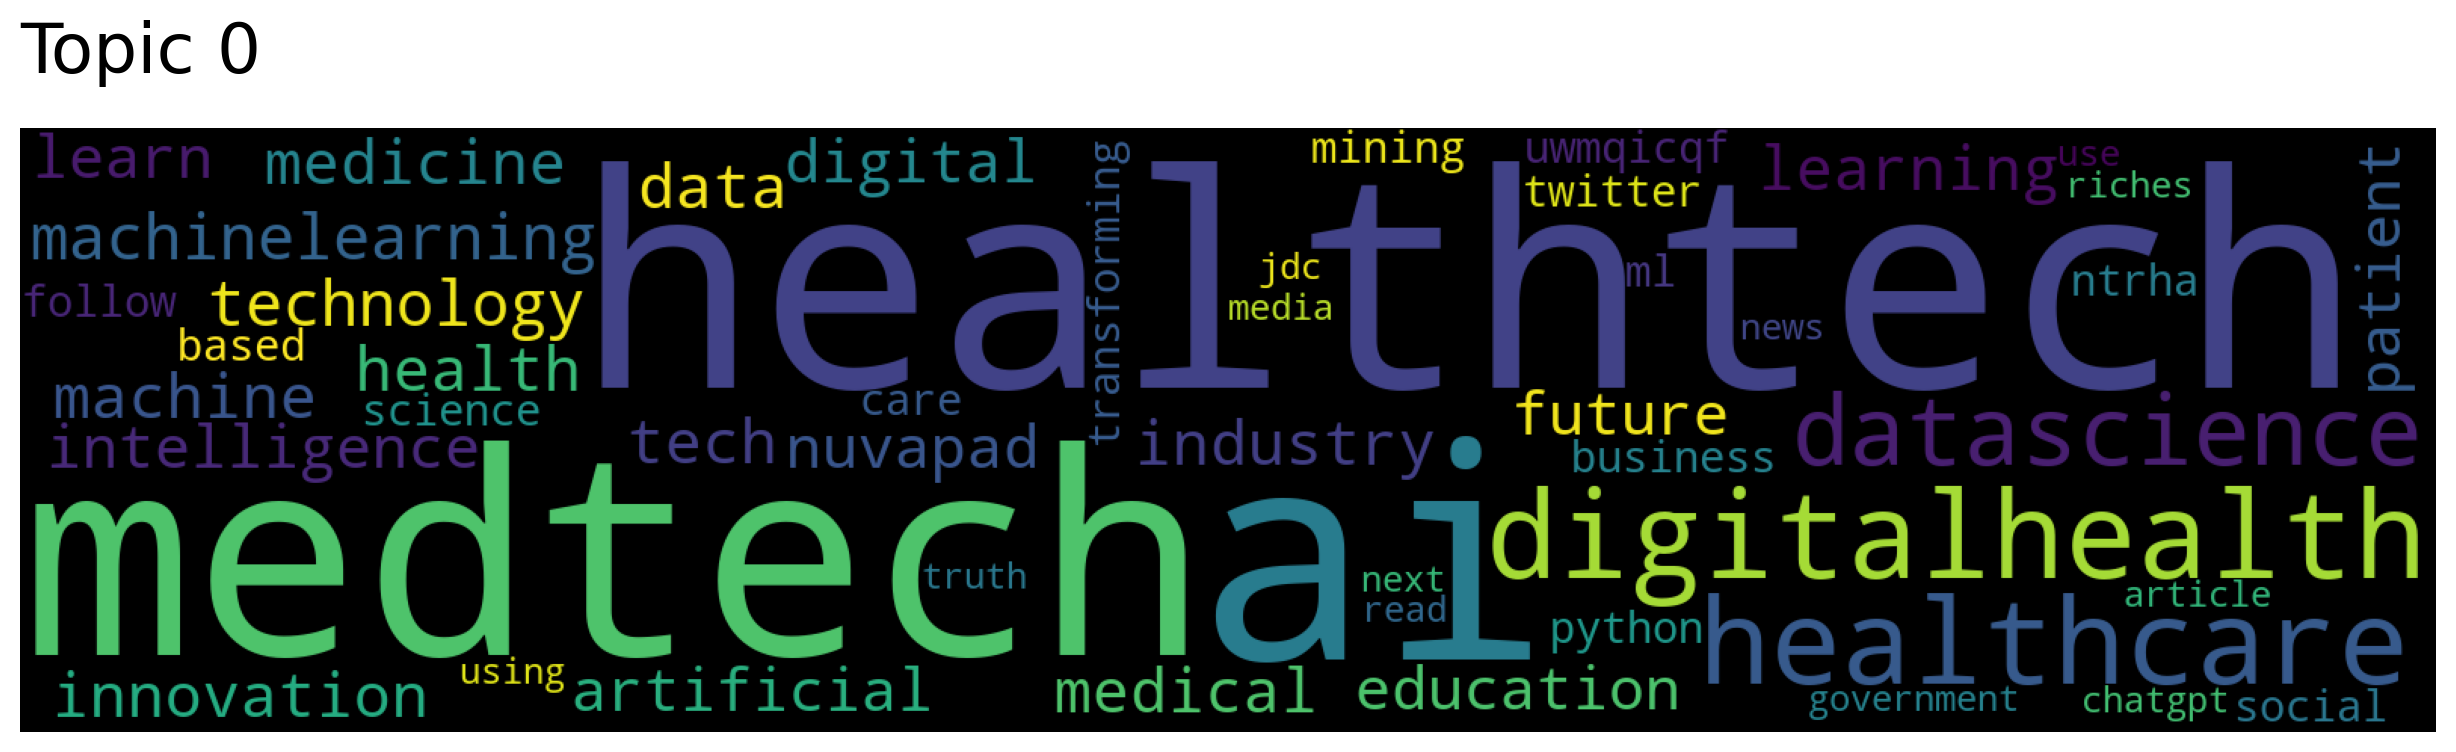

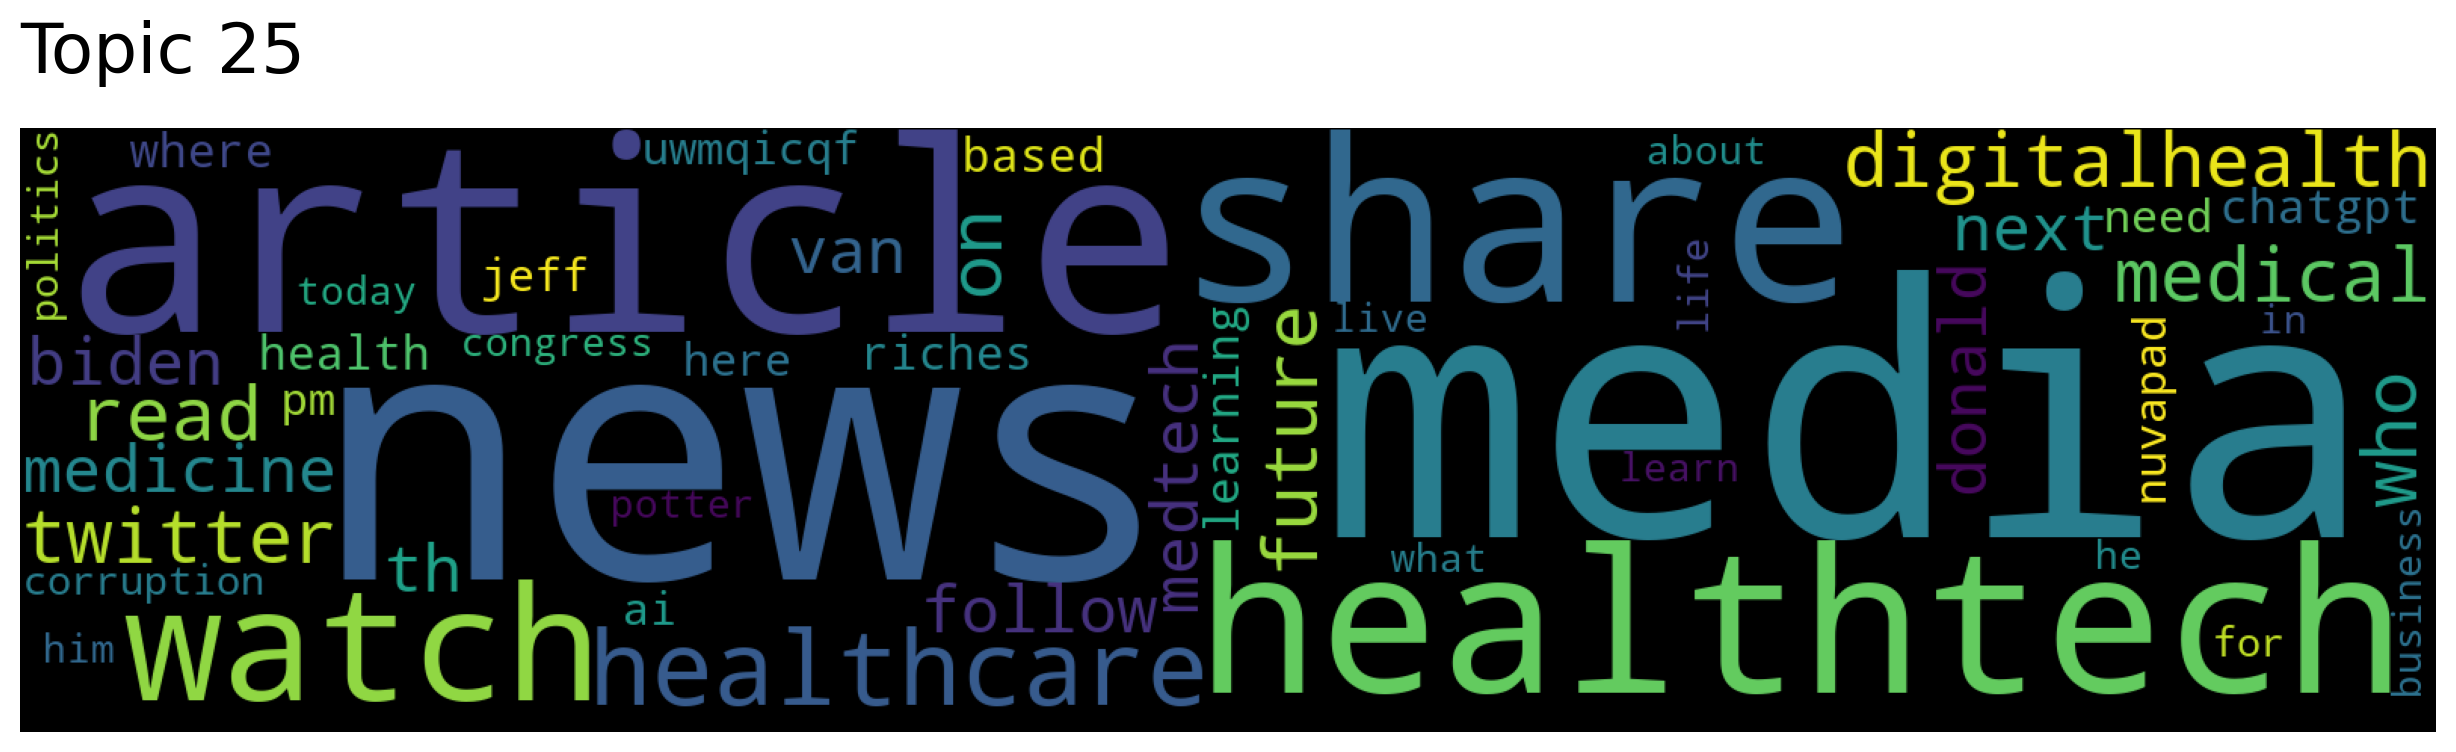

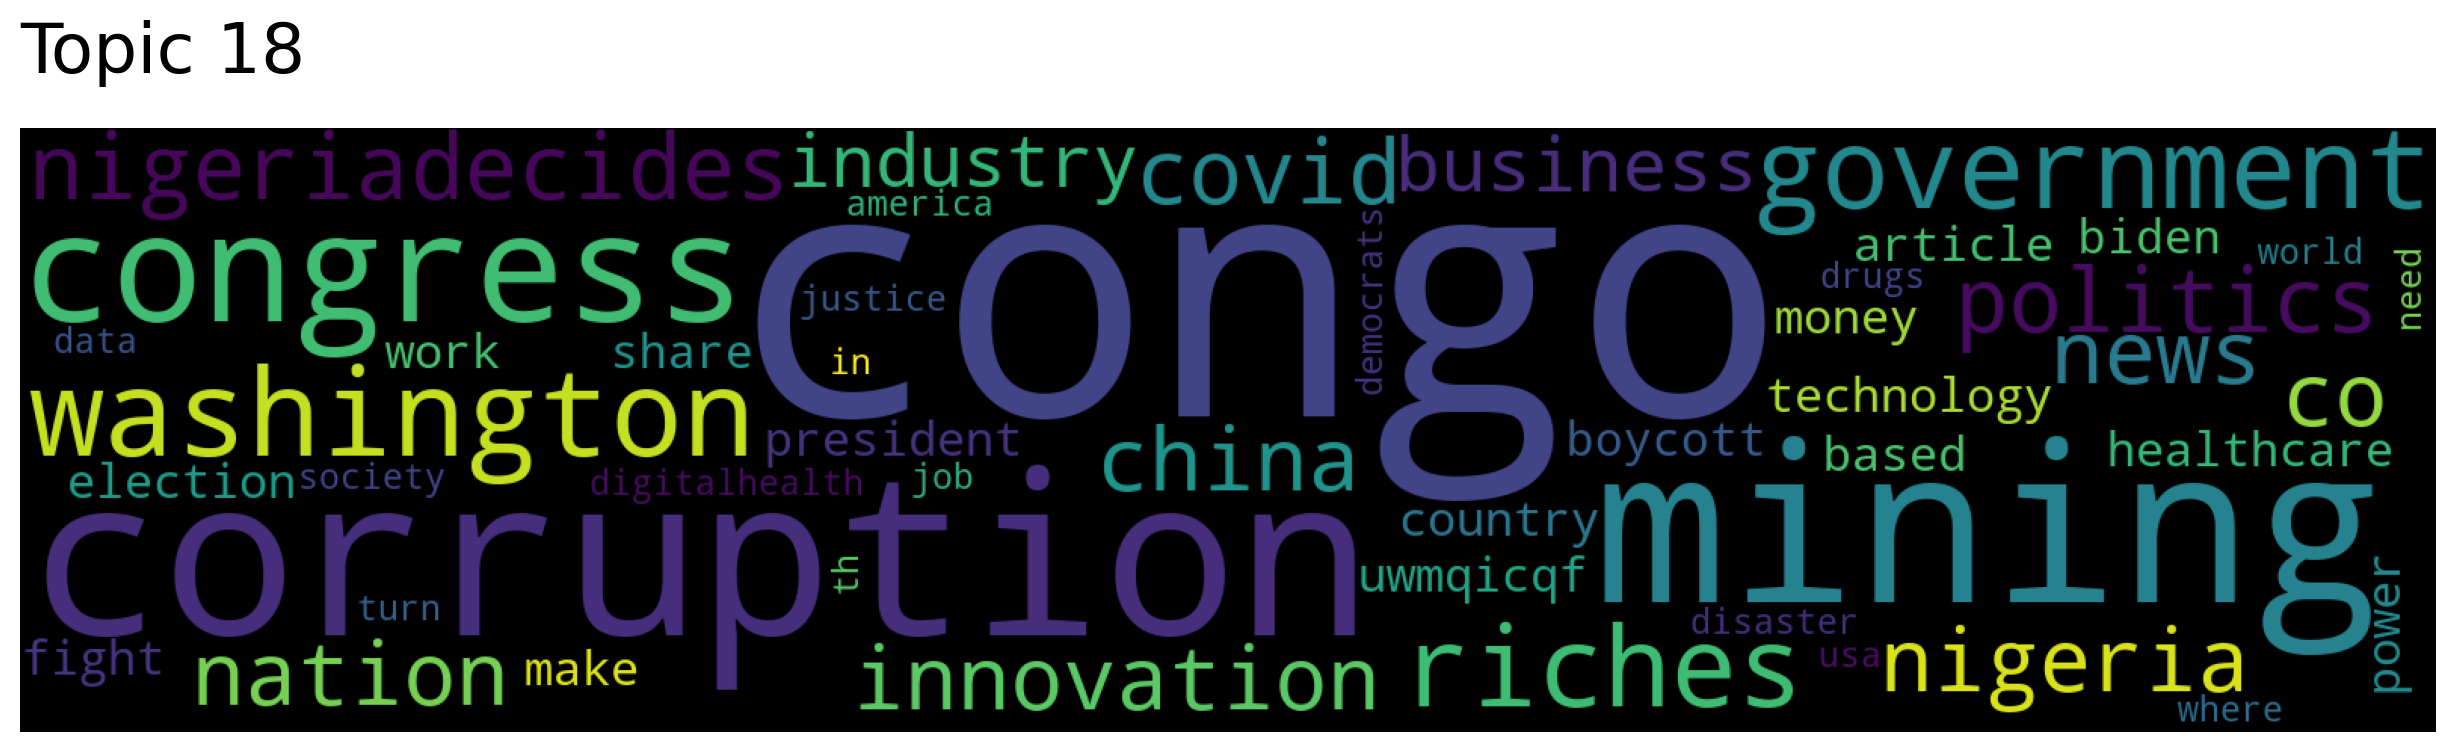

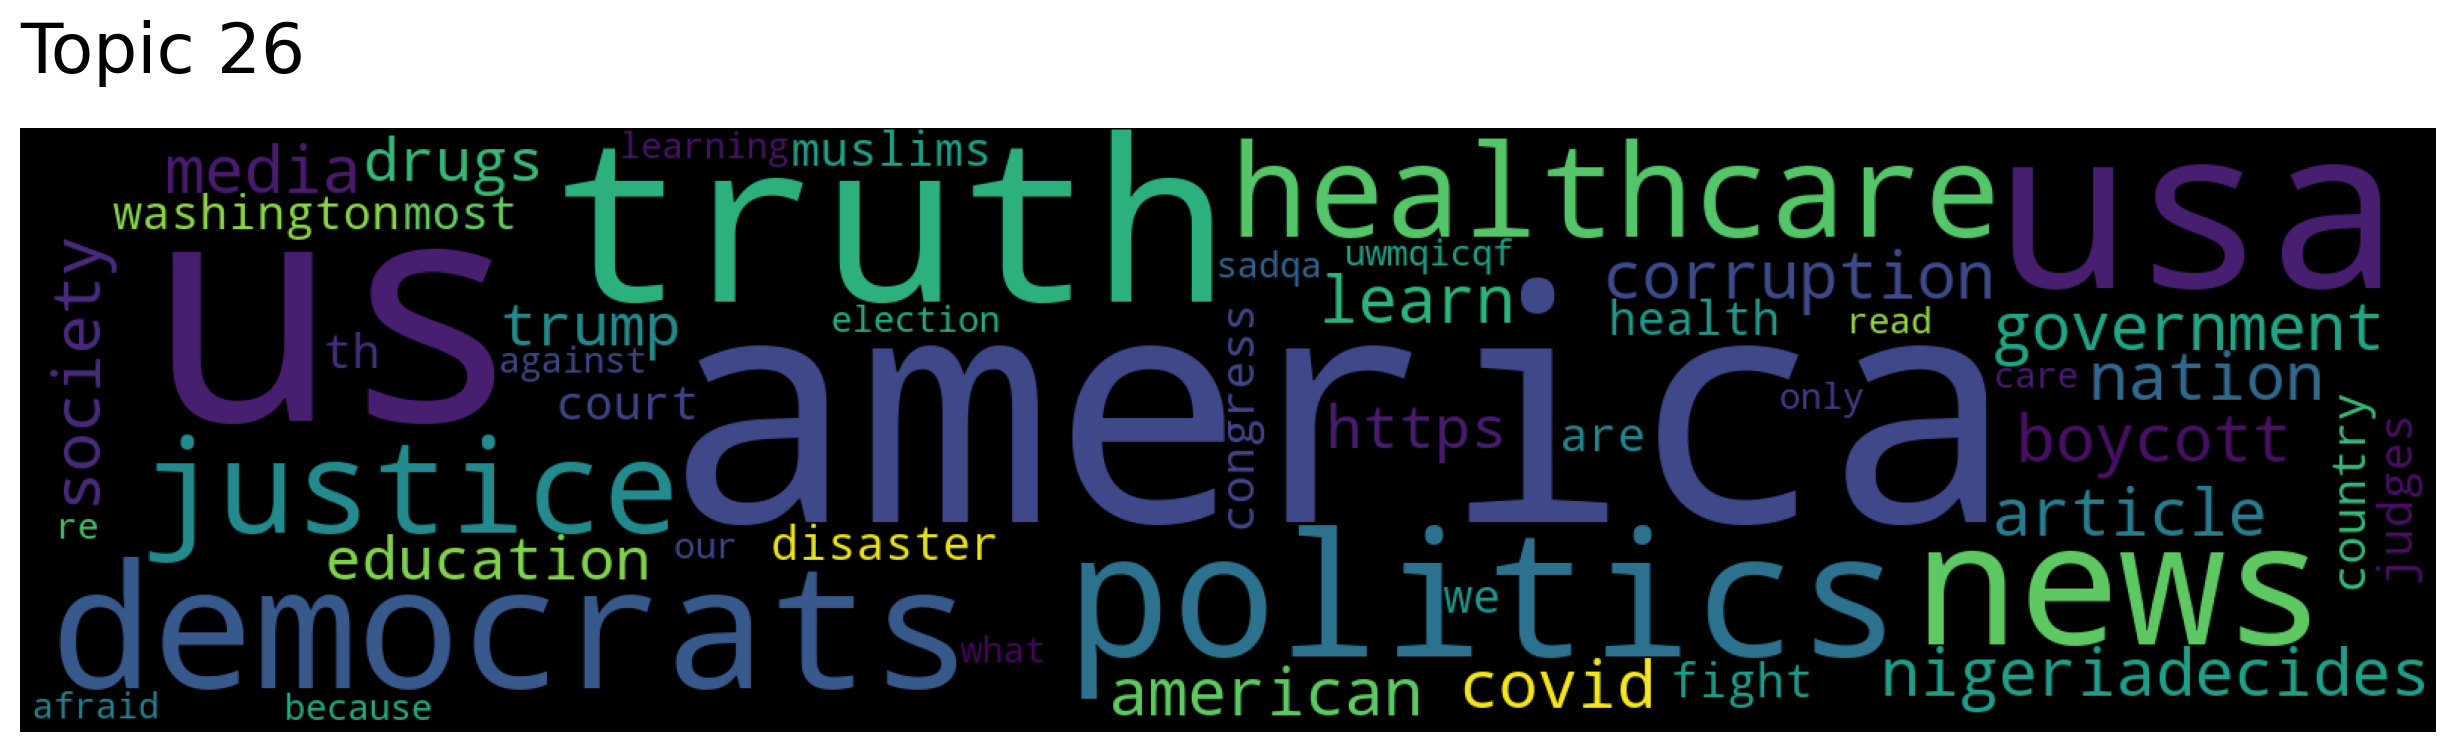

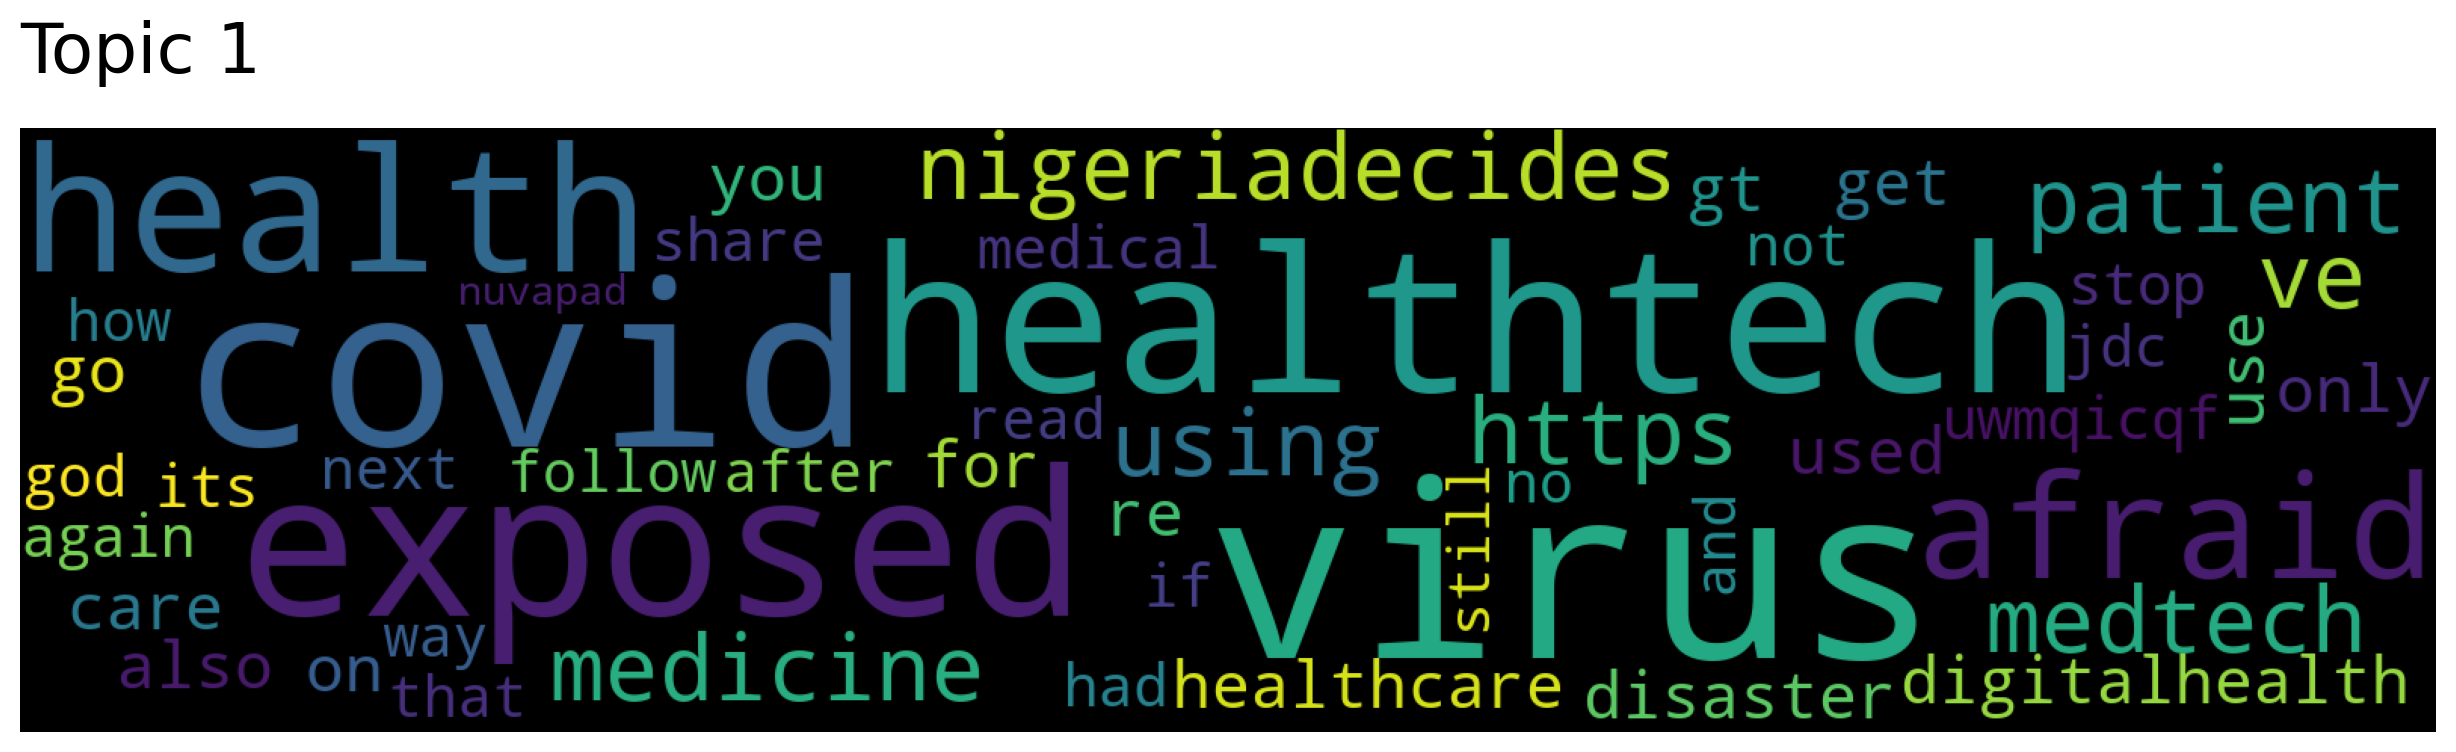

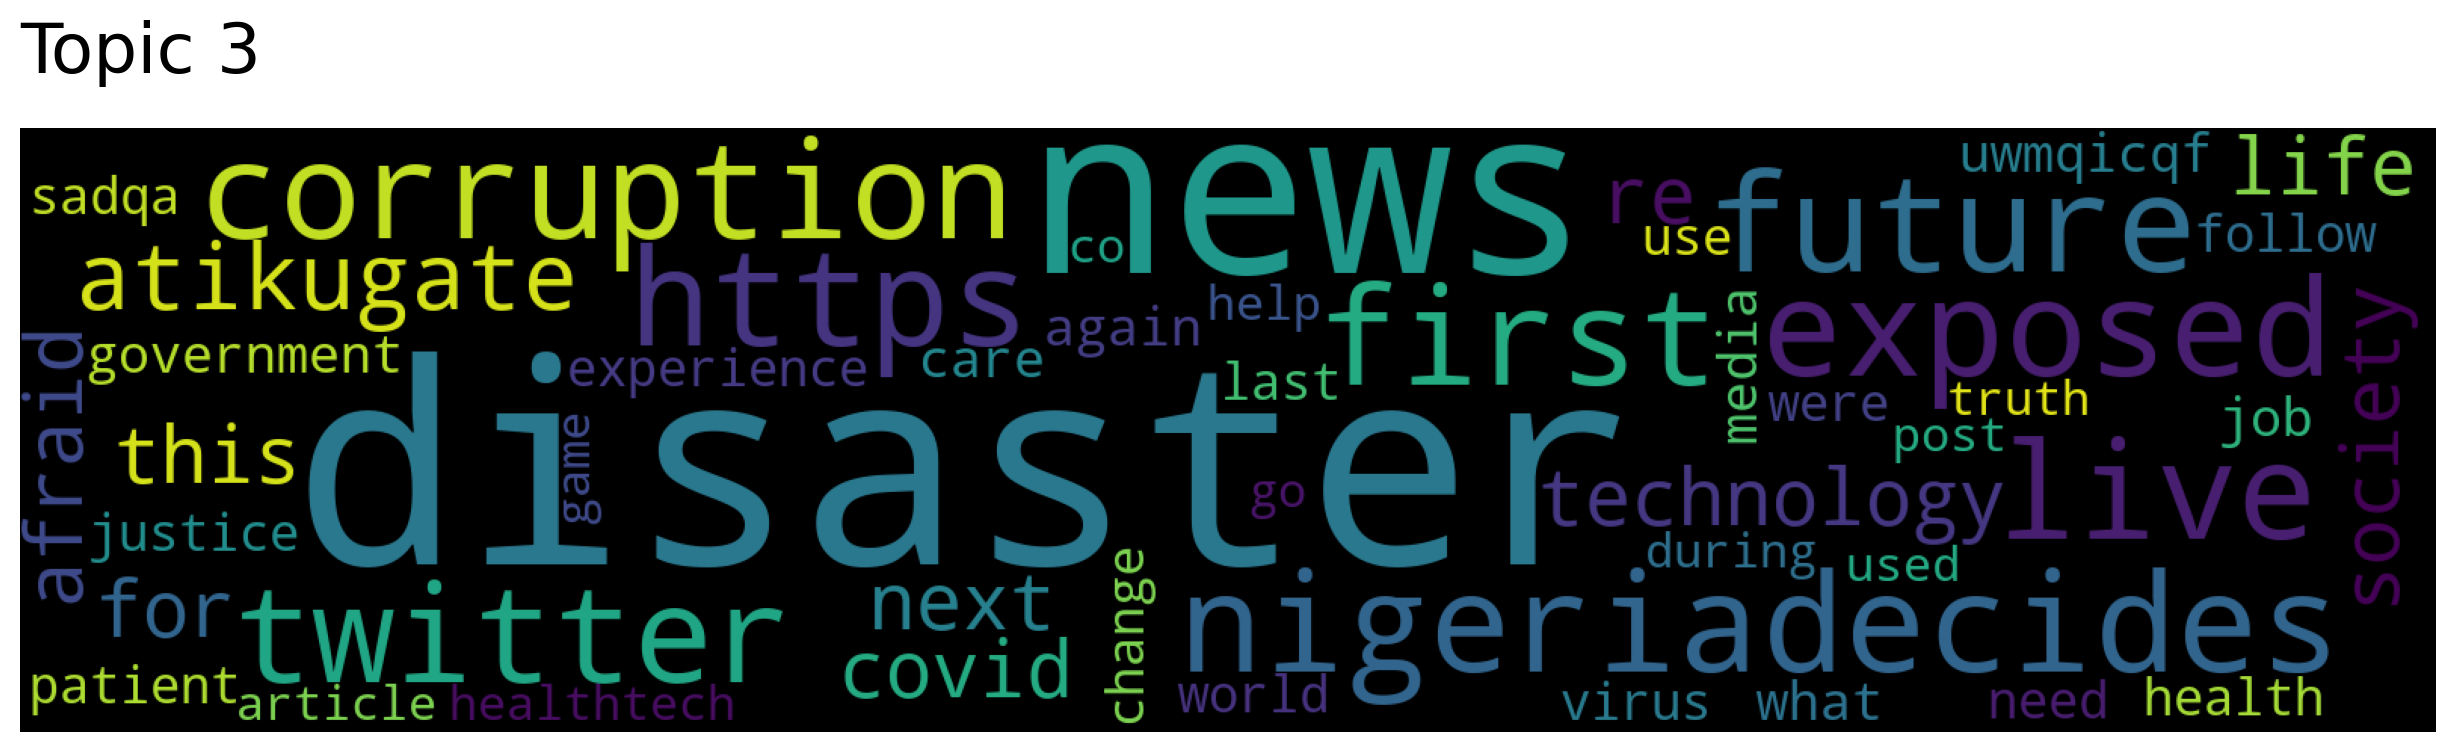

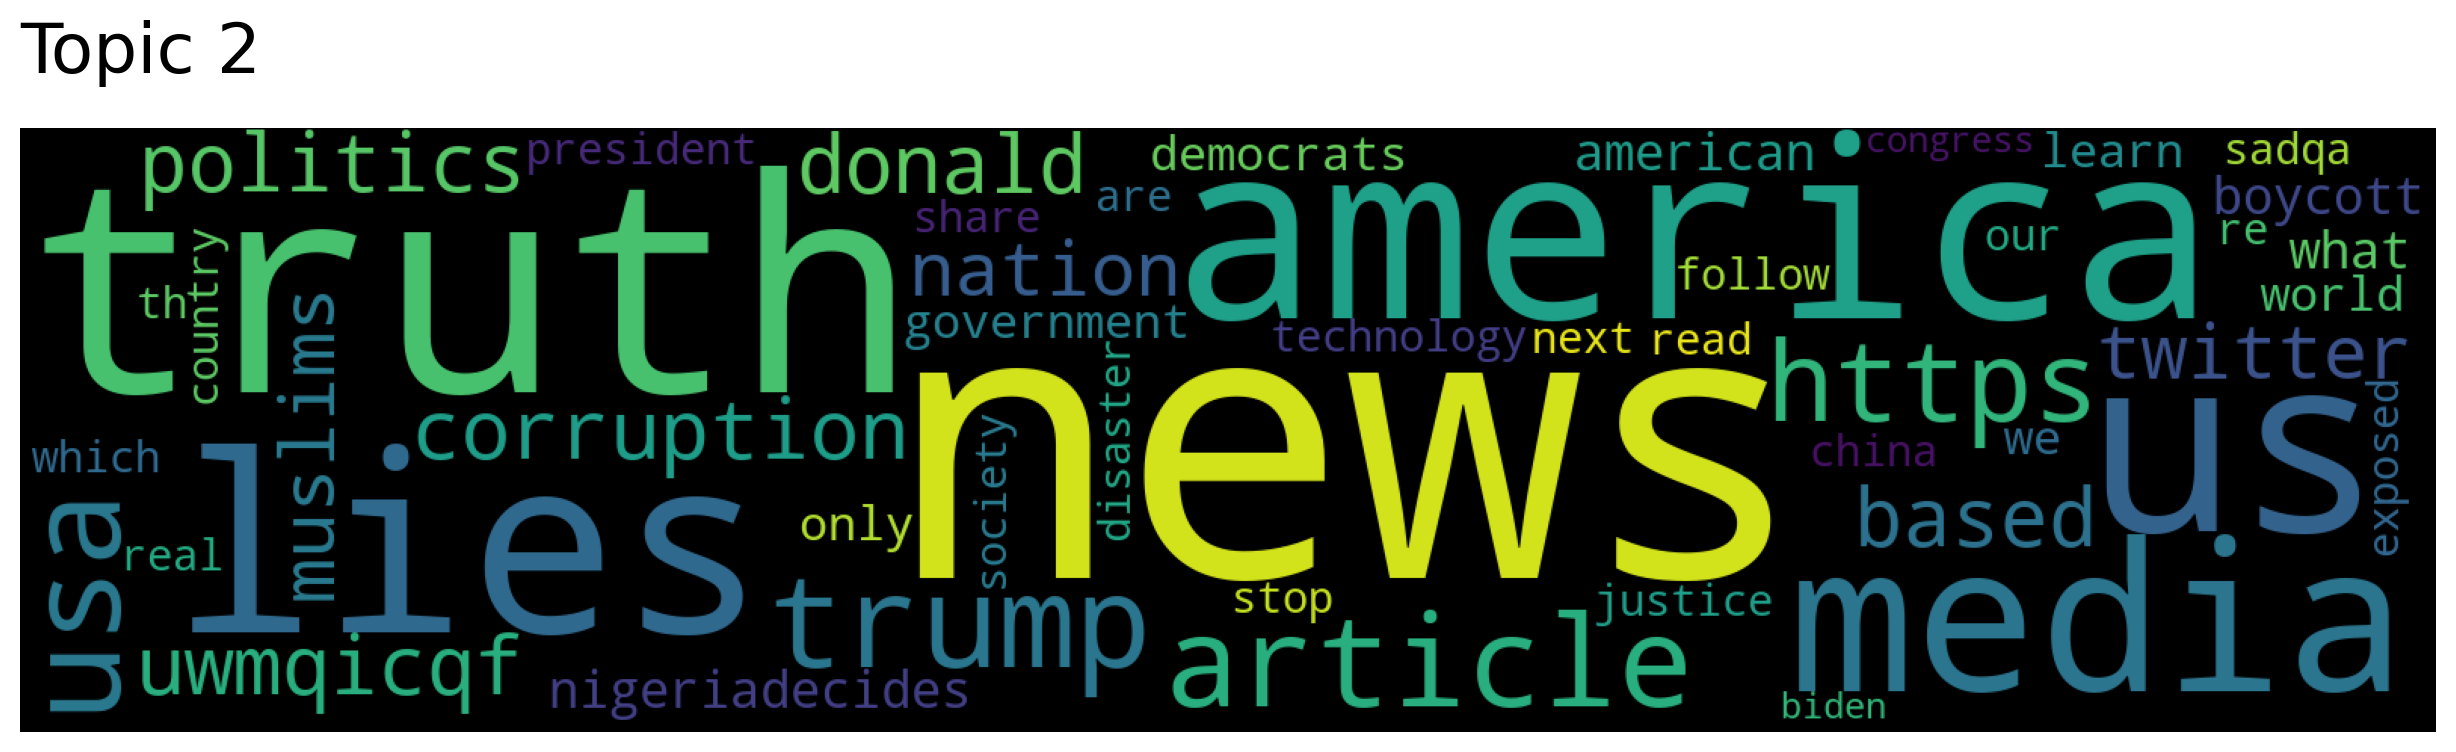

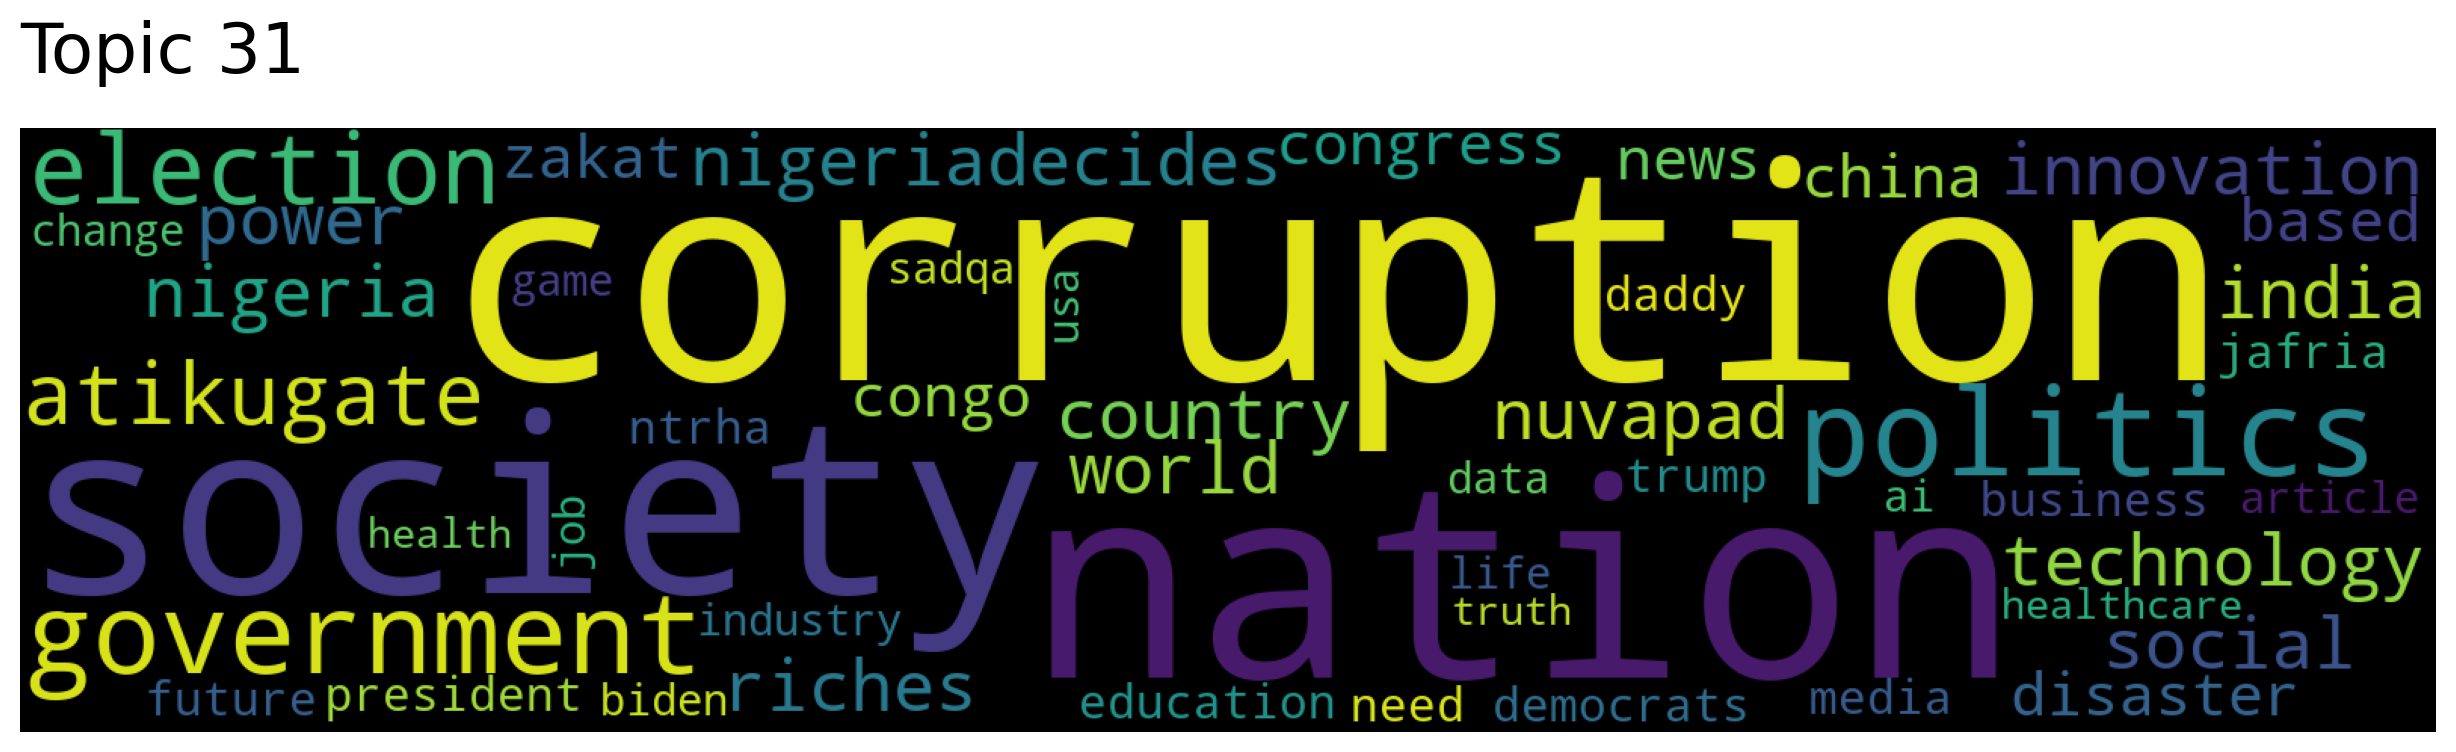

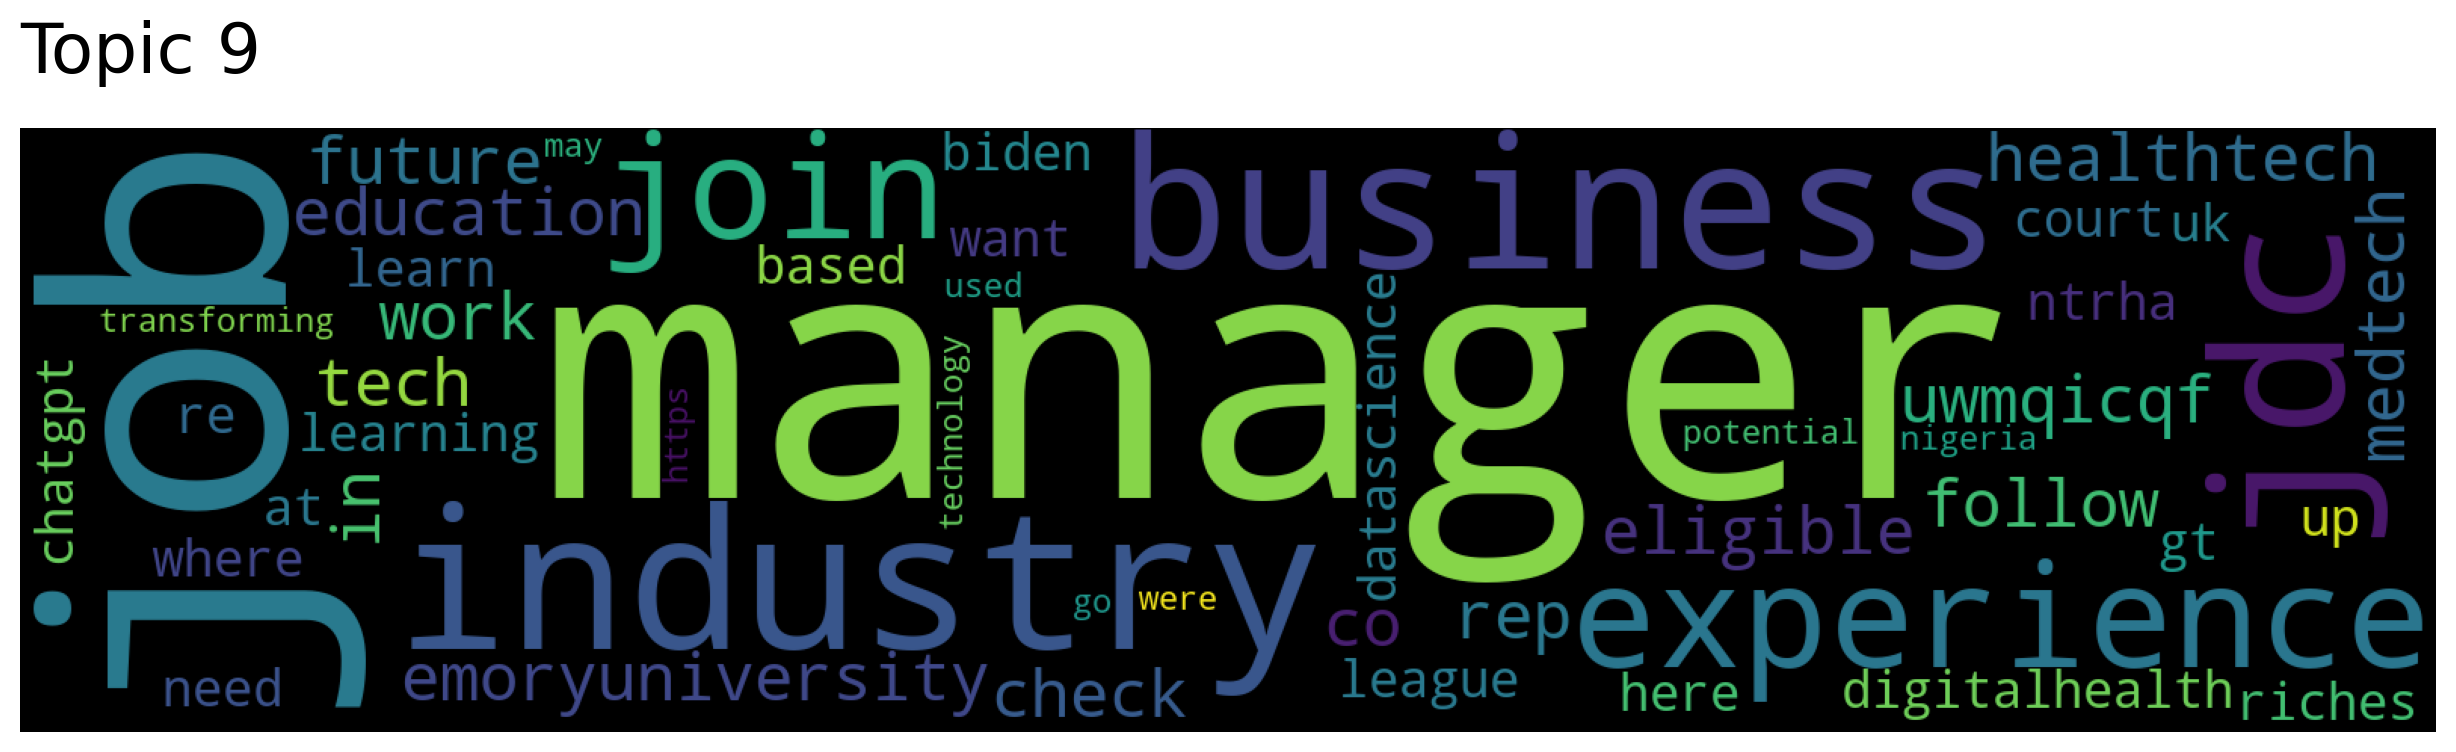

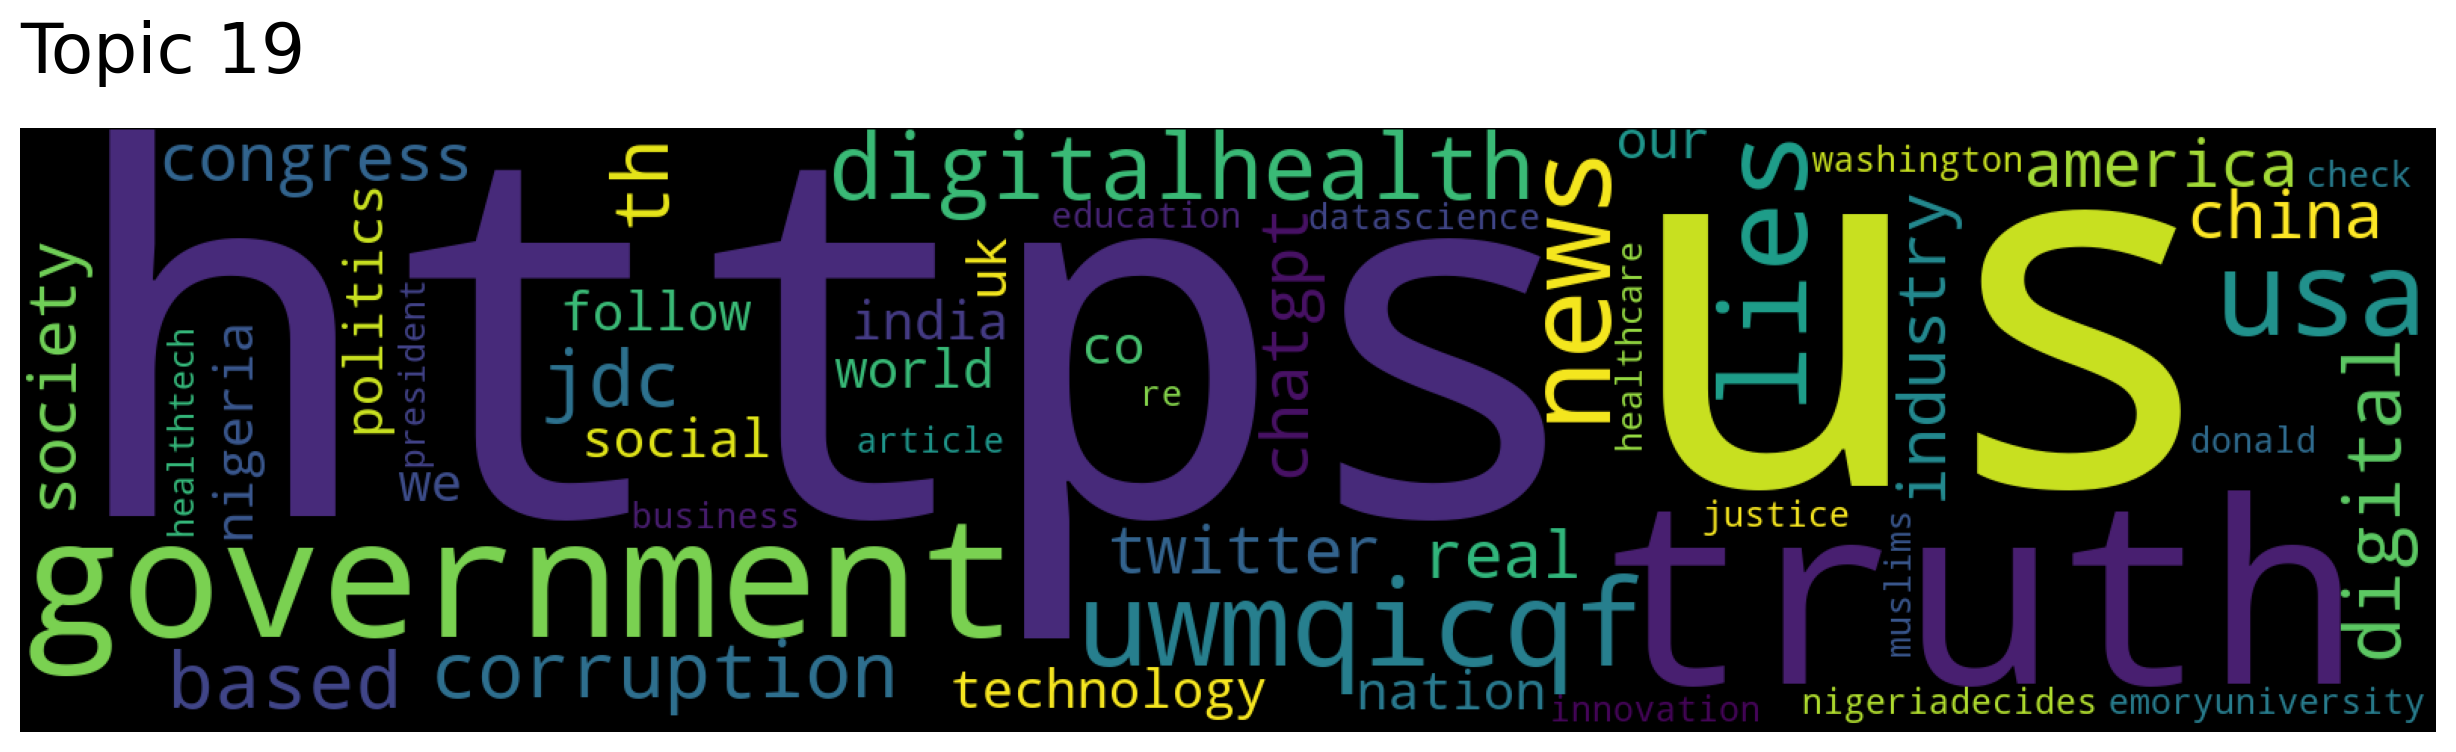

In [42]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

**Getting the topics for document(s)**

Get document topics.

The topic of each document will be returned.

The corresponding original topics are returned unless reduced=True,
in which case the reduced topics will be returned.

In [43]:
doc_topics, doc_dist, topic_words, topic_word_scores = model.get_documents_topics(doc_ids=[0,1],num_topics=5)

In [44]:
featured_data.text[:2].tolist()

['"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm',
 'When @ViolavonCramon\nflies to Georgia 🇬🇪 to take part in a protest to support a person accused of using molotov cocktails against the police, who pays her expenses?\n\n#100corruptMEPs\n#zombieNGOs #Corruption\n\n@KubiliusA\n@shpapuashvili\n@AnnaFotyga_PE \n\nhttps://t.co/bS4NsgewiK']

In [45]:
for doc_topic, dist, topic_word, topic_word_score in zip(doc_topics, doc_dist, topic_words, topic_word_scores):
    print(f"Topic number: {doc_topic}\nDocument distribution: {dist}\nTopic words: \n{topic_word}\n")
    print("----------")

Topic number: [10  7 12  2 31]
Document distribution: [0.54627955 0.45887625 0.39124304 0.3690744  0.34740067]
Topic words: 
[['corruption' 'politics' 'government' 'election' 'congress' 'democrats'
  'society' 'trump' 'riches' 'donald' 'president' 'power' 'drugs'
  'disaster' 'innovation' 'news' 'nigeriadecides' 'business' 'media'
  'money' 'nation' 'truth' 'america' 'social' 'education' 'change'
  'learn' 'technology' 'atikugate' 'based' 'justice' 'industry' 'china'
  'country' 'healthcare' 'congo' 'world' 'are' 'nigeria' 'biden' 'mining'
  'than' 'transforming' 'india' 'which' 'lies' 'party' 'most' 'life'
  'article']
 ['corruption' 'trump' 'politics' 'congress' 'donald' 'election'
  'democrats' 'news' 'president' 'justice' 'government' 'court' 'riches'
  'lies' 'next' 'of' 'drugs' 'media' 'for' 'article' 'what' 'case'
  'truth' 'biden' 'which' 'rep' 'covid' 'change' 'based' 'th' 'and'
  'real' 'disaster' 'washington' 'america' 'against' 'watch' 'who' 'as'
  'read' 'his' 'him' 'data'